In [1]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
import numpy as np
from numba import njit
import statsmodels.api as sm

In [2]:
@njit
def f(z, Œº, Œ£):
    """
    The density function of multivariate normal distribution.

    Parameters
    ---------------
    z: ndarray(float, dim=2)
        random vector, N by 1
    Œº: ndarray(float, dim=1 or 2)
        the mean of z, N by 1
    Œ£: ndarray(float, dim=2)
        the covarianece matrix of z, N by 1
    """

    z = np.atleast_2d(z)
    Œº = np.atleast_2d(Œº)
    Œ£ = np.atleast_2d(Œ£)

    N = z.size

    temp1 = np.linalg.det(Œ£) ** (-1/2)
    temp2 = np.exp(-.5 * (z - Œº).T @ np.linalg.inv(Œ£) @ (z - Œº))

    return (2 * np.pi) ** (-N/2) * temp1 * temp2

In [3]:
class MultivariateNormal:
    """
    Class of multivariate normal distribution.

    Parameters
    ----------
    Œº: ndarray(float, dim=1)
        the mean of z, N by 1
    Œ£: ndarray(float, dim=2)
        the covarianece matrix of z, N by 1

    Arguments
    ---------
    Œº, Œ£:
        see parameters
    Œºs: list(ndarray(float, dim=1))
        list of mean vectors Œº1 and Œº2 in order
    Œ£s: list(list(ndarray(float, dim=2)))
        2 dimensional list of covariance matrices
        Œ£11, Œ£12, Œ£21, Œ£22 in order
    Œ≤s: list(ndarray(float, dim=1))
        list of regression coefficients Œ≤1 and Œ≤2 in order
    """

    def __init__(self, Œº, Œ£):
        "initialization"
        self.Œº = np.array(Œº)
        self.Œ£ = np.atleast_2d(Œ£)

    def partition(self, k):
        """
        Given k, partition the random vector z into a size k vector z1
        and a size N-k vector z2. Partition the mean vector Œº into
        Œº1 and Œº2, and the covariance matrix Œ£ into Œ£11, Œ£12, Œ£21, Œ£22
        correspondingly. Compute the regression coefficients Œ≤1 and Œ≤2
        using the partitioned arrays.
        """
        Œº = self.Œº
        Œ£ = self.Œ£

        self.Œºs = [Œº[:k], Œº[k:]]
        self.Œ£s = [[Œ£[:k, :k], Œ£[:k, k:]],
                   [Œ£[k:, :k], Œ£[k:, k:]]]

        self.Œ≤s = [self.Œ£s[0][1] @ np.linalg.inv(self.Œ£s[1][1]),
                   self.Œ£s[1][0] @ np.linalg.inv(self.Œ£s[0][0])]

    def cond_dist(self, ind, z):
        """
        Compute the conditional distribution of z1 given z2, or reversely.
        Argument ind determines whether we compute the conditional
        distribution of z1 (ind=0) or z2 (ind=1).

        Returns
        ---------
        Œº_hat: ndarray(float, ndim=1)
            The conditional mean of z1 or z2.
        Œ£_hat: ndarray(float, ndim=2)
            The conditional covariance matrix of z1 or z2.
        """
        Œ≤ = self.Œ≤s[ind]
        Œºs = self.Œºs
        Œ£s = self.Œ£s

        Œº_hat = Œºs[ind] + Œ≤ @ (z - Œºs[1-ind])
        Œ£_hat = Œ£s[ind][ind] - Œ≤ @ Œ£s[1-ind][1-ind] @ Œ≤.T

        return Œº_hat, Œ£_hat

In [4]:
Œº = np.array([.5, 1.])
Œ£ = np.array([[1., .5], [.5 ,1.]])

# construction of the multivariate normal instance
multi_normal = MultivariateNormal(Œº, Œ£)

In [5]:
k = 1 # choose partition

# partition and compute regression coefficients
multi_normal.partition(k)
multi_normal.Œ≤s[0],multi_normal.Œ≤s[1]

(array([[0.5]]), array([[0.5]]))

In [6]:
beta = multi_normal.Œ≤s

a1 = Œº[0] - beta[0]*Œº[1]
b1 = beta[0]

a2 = Œº[1] - beta[1]*Œº[0]
b2 = beta[1]

In [7]:
print ("a1 = ", a1)
print ("b1 = ", b1)

a1 =  [[0.]]
b1 =  [[0.5]]


In [8]:
print ("a2 = ", a2)
print ("b2 = ", b2)

a2 =  [[0.75]]
b2 =  [[0.5]]


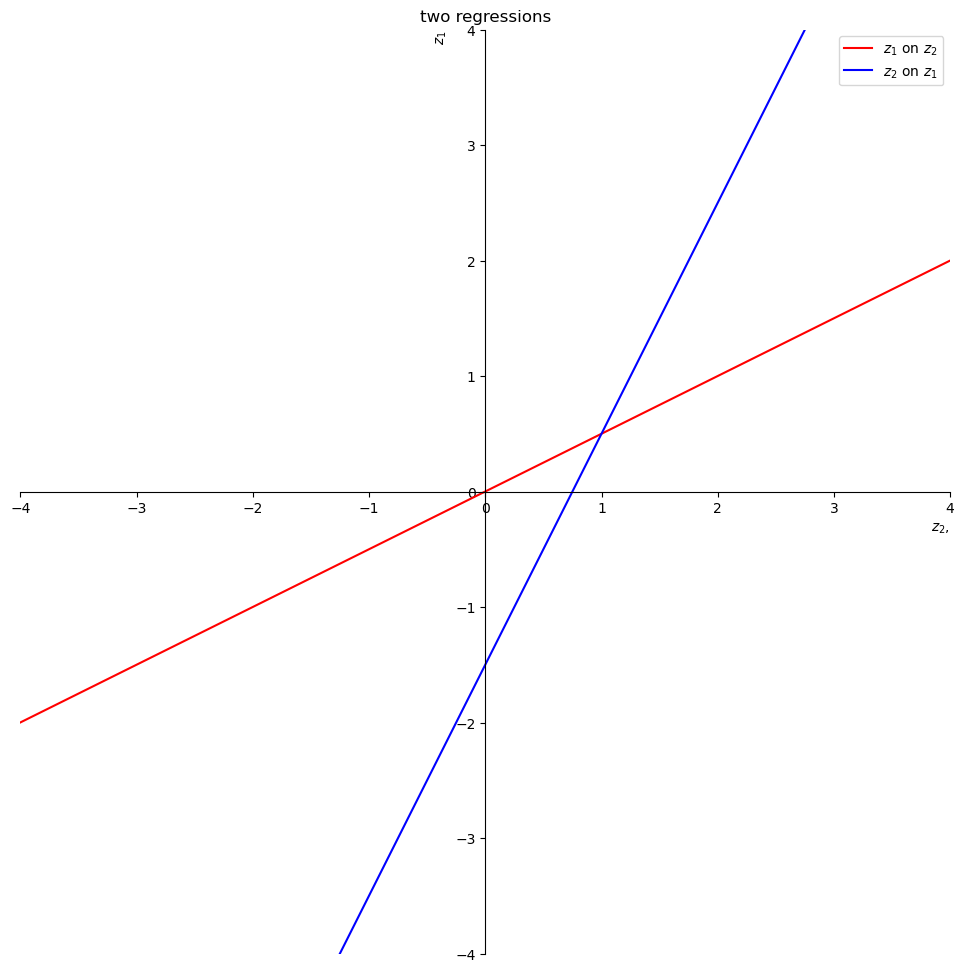

In [9]:
z2 = np.linspace(-4,4,100)


a1 = np.squeeze(a1)
b1 = np.squeeze(b1)

a2 = np.squeeze(a2)
b2 = np.squeeze(b2)

z1  = b1*z2 + a1


z1h = z2/b2 - a2/b2


fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(1, 1, 1)
ax.set(xlim=(-4, 4), ylim=(-4, 4))
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
plt.ylabel('$z_1$', loc = 'top')
plt.xlabel('$z_2$,', loc = 'right')
plt.title('two regressions')
plt.plot(z2,z1, 'r', label = "$z_1$ on $z_2$")
plt.plot(z2,z1h, 'b', label = "$z_2$ on $z_1$")
plt.legend()
plt.show()

In [10]:
print("a1 = ", a1)
print("b1 = ", b1)

a1 =  0.0
b1 =  0.5


In [11]:
print("-a2/b2 = ", - a2/b2)
print("1/b2 = ", 1/b2)

-a2/b2 =  -1.5
1/b2 =  2.0


In [12]:
# compute the cond. dist. of z1
ind = 1
z1 = np.array([5.]) # given z1

Œº2_hat, Œ£2_hat = multi_normal.cond_dist(ind, z1)
print('Œº2_hat, Œ£2_hat = ', Œº2_hat, Œ£2_hat)

Œº2_hat, Œ£2_hat =  [3.25] [[0.75]]


In [13]:
# compute the cond. dist. of z1
ind = 0
z2 = np.array([5.]) # given z2

Œº1_hat, Œ£1_hat = multi_normal.cond_dist(ind, z2)
print('Œº1_hat, Œ£1_hat = ', Œº1_hat, Œ£1_hat)

Œº1_hat, Œ£1_hat =  [2.5] [[0.75]]


In [14]:
n = 1_000_000 # sample size

# simulate multivariate normal random vectors
data = np.random.multivariate_normal(Œº, Œ£, size=n)
z1_data = data[:, 0]
z2_data = data[:, 1]

# OLS regression
Œº1, Œº2 = multi_normal.Œºs
results = sm.OLS(z1_data - Œº1, z2_data - Œº2).fit()

In [15]:
multi_normal.Œ≤s[0], results.params

(array([[0.5]]), array([0.50081614]))

In [16]:
Œ£1_hat, results.resid @ results.resid.T / (n - 1)

(array([[0.75]]), 0.7505173364615084)

In [17]:
Œº1_hat, results.predict(z2 - Œº2) + Œº1

(array([2.5]), array([2.50326456]))

In [18]:
Œº = np.random.random(3)
C = np.random.random((3, 3))
Œ£ = C @ C.T # positive semi-definite

multi_normal = MultivariateNormal(Œº, Œ£)

In [19]:
Œº, Œ£

(array([0.70104441, 0.27024756, 0.26236027]),
 array([[0.84738474, 0.52577963, 1.06540156],
        [0.52577963, 0.66684744, 1.15168643],
        [1.06540156, 1.15168643, 2.23520061]]))

In [20]:
k = 1
multi_normal.partition(k)

In [21]:
ind = 0
z2 = np.array([2., 5.])

Œº1_hat, Œ£1_hat = multi_normal.cond_dist(ind, z2)

In [22]:
n = 1_000_000
data = np.random.multivariate_normal(Œº, Œ£, size=n)
z1_data = data[:, :k]
z2_data = data[:, k:]

In [23]:
Œº1, Œº2 = multi_normal.Œºs
results = sm.OLS(z1_data - Œº1, z2_data - Œº2).fit()

In [24]:
multi_normal.Œ≤s[0], results.params

(array([[-0.3154653 ,  0.63919035]]), array([-0.3176332 ,  0.64049458]))

In [25]:
Œ£1_hat, results.resid @ results.resid.T / (n - 1)

(array([[0.33225557]]), 0.33284981991725127)

In [26]:
Œº1_hat, results.predict(z2 - Œº2) + Œº1

(array([3.18362114]), array([3.1860502]))

In [27]:
def construct_moments_IQ(n, ŒºŒ∏, œÉŒ∏, œÉy):

    Œº_IQ = np.full(n+1, ŒºŒ∏)

    D_IQ = np.zeros((n+1, n+1))
    D_IQ[range(n), range(n)] = œÉy
    D_IQ[:, n] = œÉŒ∏

    Œ£_IQ = D_IQ @ D_IQ.T

    return Œº_IQ, Œ£_IQ, D_IQ

In [28]:
n = 50
ŒºŒ∏, œÉŒ∏, œÉy = 100., 10., 10.

Œº_IQ, Œ£_IQ, D_IQ = construct_moments_IQ(n, ŒºŒ∏, œÉŒ∏, œÉy)
Œº_IQ, Œ£_IQ, D_IQ

(array([100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100.]),
 array([[200., 100., 100., ..., 100., 100., 100.],
        [100., 200., 100., ..., 100., 100., 100.],
        [100., 100., 200., ..., 100., 100., 100.],
        ...,
        [100., 100., 100., ..., 200., 100., 100.],
        [100., 100., 100., ..., 100., 200., 100.],
        [100., 100., 100., ..., 100., 100., 100.]]),
 array([[10.,  0.,  0., ...,  0.,  0., 10.],
        [ 0., 10.,  0., ...,  0.,  0., 10.],
        [ 0.,  0., 10., ...,  0.,  0., 10.],
        ...,
        [ 0.,  0.,  0., ..., 10.,  0., 10.],
        [ 0.,  0.,  0., ...,  0., 10., 10.],
        [ 0.,  0.,  0., ...,  0.,  0., 10.]]))

In [29]:
multi_normal_IQ = MultivariateNormal(Œº_IQ, Œ£_IQ)

k = n
multi_normal_IQ.partition(k)

In [30]:
x = np.random.multivariate_normal(Œº_IQ, Œ£_IQ)
y = x[:-1] # test scores
Œ∏ = x[-1]  # IQ

In [31]:
# the true value
Œ∏

92.08656670315838

In [32]:
ind = 1
multi_normal_IQ.cond_dist(ind, y)

(array([90.64931942]), array([[1.96078431]]))

In [33]:
# array for containing moments
ŒºŒ∏_hat_arr = np.empty(n)
Œ£Œ∏_hat_arr = np.empty(n)

# loop over number of test scores
for i in range(1, n+1):
    # construction of multivariate normal distribution instance
    Œº_IQ_i, Œ£_IQ_i, D_IQ_i = construct_moments_IQ(i, ŒºŒ∏, œÉŒ∏, œÉy)
    multi_normal_IQ_i = MultivariateNormal(Œº_IQ_i, Œ£_IQ_i)

    # partition and compute conditional distribution
    multi_normal_IQ_i.partition(i)
    scores_i = y[:i]
    ŒºŒ∏_hat_i, Œ£Œ∏_hat_i = multi_normal_IQ_i.cond_dist(1, scores_i)

    # store the results
    ŒºŒ∏_hat_arr[i-1] = ŒºŒ∏_hat_i[0]
    Œ£Œ∏_hat_arr[i-1] = Œ£Œ∏_hat_i[0, 0]

# transform variance to standard deviation
œÉŒ∏_hat_arr = np.sqrt(Œ£Œ∏_hat_arr)

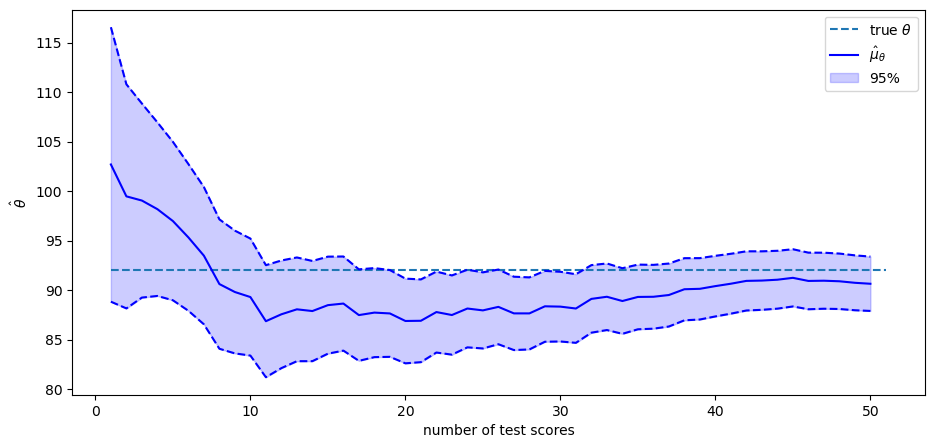

In [34]:
ŒºŒ∏_hat_lower = ŒºŒ∏_hat_arr - 1.96 * œÉŒ∏_hat_arr
ŒºŒ∏_hat_higher = ŒºŒ∏_hat_arr + 1.96 * œÉŒ∏_hat_arr

plt.hlines(Œ∏, 1, n+1, ls='--', label='true $Œ∏$')
plt.plot(range(1, n+1), ŒºŒ∏_hat_arr, color='b', label='$\hat{Œº}_{Œ∏}$')
plt.plot(range(1, n+1), ŒºŒ∏_hat_lower, color='b', ls='--')
plt.plot(range(1, n+1), ŒºŒ∏_hat_higher, color='b', ls='--')
plt.fill_between(range(1, n+1), ŒºŒ∏_hat_lower, ŒºŒ∏_hat_higher,
                 color='b', alpha=0.2, label='95%')

plt.xlabel('number of test scores')
plt.ylabel('$\hat{Œ∏}$')
plt.legend()

plt.show()

In [35]:
C = np.linalg.cholesky(Œ£_IQ)
G = np.linalg.inv(C)

Œµ = G @ (x - ŒºŒ∏)

In [36]:
cŒµ = C[n, :] * Œµ

# compute the sequence of ŒºŒ∏ and Œ£Œ∏ conditional on y1, y2, ..., yk
ŒºŒ∏_hat_arr_C = np.array([np.sum(cŒµ[:k+1]) for k in range(n)]) + ŒºŒ∏
Œ£Œ∏_hat_arr_C = np.array([np.sum(C[n, i+1:n+1] ** 2) for i in range(n)])

In [37]:
# conditional mean
np.max(np.abs(ŒºŒ∏_hat_arr - ŒºŒ∏_hat_arr_C)) < 1e-10

True

In [38]:
# conditional variance
np.max(np.abs(Œ£Œ∏_hat_arr - Œ£Œ∏_hat_arr_C)) < 1e-10

True

In [39]:
def construct_moments_IQ2d(n, ŒºŒ∏, œÉŒ∏, ŒºŒ∑, œÉŒ∑, œÉy):

    Œº_IQ2d = np.empty(2*(n+1))
    Œº_IQ2d[:n] = ŒºŒ∏
    Œº_IQ2d[2*n] = ŒºŒ∏
    Œº_IQ2d[n:2*n] = ŒºŒ∑
    Œº_IQ2d[2*n+1] = ŒºŒ∑


    D_IQ2d = np.zeros((2*(n+1), 2*(n+1)))
    D_IQ2d[range(2*n), range(2*n)] = œÉy
    D_IQ2d[:n, 2*n] = œÉŒ∏
    D_IQ2d[2*n, 2*n] = œÉŒ∏
    D_IQ2d[n:2*n, 2*n+1] = œÉŒ∑
    D_IQ2d[2*n+1, 2*n+1] = œÉŒ∑

    Œ£_IQ2d = D_IQ2d @ D_IQ2d.T

    return Œº_IQ2d, Œ£_IQ2d, D_IQ2d

In [40]:
n = 2
# mean and variance of Œ∏, Œ∑, and y
ŒºŒ∏, œÉŒ∏, ŒºŒ∑, œÉŒ∑, œÉy = 100., 10., 100., 10, 10

Œº_IQ2d, Œ£_IQ2d, D_IQ2d = construct_moments_IQ2d(n, ŒºŒ∏, œÉŒ∏, ŒºŒ∑, œÉŒ∑, œÉy)
Œº_IQ2d, Œ£_IQ2d, D_IQ2d

(array([100., 100., 100., 100., 100., 100.]),
 array([[200., 100.,   0.,   0., 100.,   0.],
        [100., 200.,   0.,   0., 100.,   0.],
        [  0.,   0., 200., 100.,   0., 100.],
        [  0.,   0., 100., 200.,   0., 100.],
        [100., 100.,   0.,   0., 100.,   0.],
        [  0.,   0., 100., 100.,   0., 100.]]),
 array([[10.,  0.,  0.,  0., 10.,  0.],
        [ 0., 10.,  0.,  0., 10.,  0.],
        [ 0.,  0., 10.,  0.,  0., 10.],
        [ 0.,  0.,  0., 10.,  0., 10.],
        [ 0.,  0.,  0.,  0., 10.,  0.],
        [ 0.,  0.,  0.,  0.,  0., 10.]]))

In [41]:
# take one draw
x = np.random.multivariate_normal(Œº_IQ2d, Œ£_IQ2d)
y1 = x[:n]
y2 = x[n:2*n]
Œ∏ = x[2*n]
Œ∑ = x[2*n+1]

# the true values
Œ∏, Œ∑

(101.06907604337245, 112.42438536924284)

In [42]:
multi_normal_IQ2d = MultivariateNormal(Œº_IQ2d, Œ£_IQ2d)

k = 2*n # the length of data vector
multi_normal_IQ2d.partition(k)

multi_normal_IQ2d.cond_dist(1, [*y1, *y2])

(array([ 94.29880282, 106.56055143]),
 array([[33.33333333,  0.        ],
        [ 0.        , 33.33333333]]))

In [43]:
def cond_dist_IQ2d(Œº, Œ£, data):

    n = len(Œº)

    multi_normal = MultivariateNormal(Œº, Œ£)
    multi_normal.partition(n-1)
    Œº_hat, Œ£_hat = multi_normal.cond_dist(1, data)

    return Œº_hat, Œ£_hat

In [44]:
for indices, IQ, conditions in [([*range(2*n), 2*n], 'Œ∏', 'y1, y2, y3, y4'),
                                ([*range(n), 2*n], 'Œ∏', 'y1, y2'),
                                ([*range(n, 2*n), 2*n], 'Œ∏', 'y3, y4'),
                                ([*range(2*n), 2*n+1], 'Œ∑', 'y1, y2, y3, y4'),
                                ([*range(n), 2*n+1], 'Œ∑', 'y1, y2'),
                                ([*range(n, 2*n), 2*n+1], 'Œ∑', 'y3, y4')]:

    Œº_hat, Œ£_hat = cond_dist_IQ2d(Œº_IQ2d[indices], Œ£_IQ2d[indices][:, indices], x[indices[:-1]])
    print(f'The mean and variance of {IQ} conditional on {conditions: <15} are ' +
          f'{Œº_hat[0]:1.2f} and {Œ£_hat[0, 0]:1.2f} respectively')

The mean and variance of Œ∏ conditional on y1, y2, y3, y4  are 94.30 and 33.33 respectively
The mean and variance of Œ∏ conditional on y1, y2          are 94.30 and 33.33 respectively
The mean and variance of Œ∏ conditional on y3, y4          are 100.00 and 100.00 respectively
The mean and variance of Œ∑ conditional on y1, y2, y3, y4  are 106.56 and 33.33 respectively
The mean and variance of Œ∑ conditional on y1, y2          are 100.00 and 100.00 respectively
The mean and variance of Œ∑ conditional on y3, y4          are 106.56 and 33.33 respectively


In [45]:
# as an example, consider the case where T = 3
T = 3

In [46]:
# variance of the initial distribution x_0
œÉ0 = 1.

# parameters of the equation system
a = .9
b = 1.
c = 1.0
d = .05

In [47]:
# construct the covariance matrix of X
Œ£x = np.empty((T+1, T+1))

Œ£x[0, 0] = œÉ0 ** 2
for i in range(T):
    Œ£x[i, i+1:] = Œ£x[i, i] * a ** np.arange(1, T+1-i)
    Œ£x[i+1:, i] = Œ£x[i, i+1:]

    Œ£x[i+1, i+1] = a ** 2 * Œ£x[i, i] + b ** 2

In [48]:
Œ£x

array([[1.      , 0.9     , 0.81    , 0.729   ],
       [0.9     , 1.81    , 1.629   , 1.4661  ],
       [0.81    , 1.629   , 2.4661  , 2.21949 ],
       [0.729   , 1.4661  , 2.21949 , 2.997541]])

In [49]:
# construct the covariance matrix of Y
C = np.eye(T+1) * c
D = np.eye(T+1) * d

Œ£y = C @ Œ£x @ C.T + D @ D.T

In [50]:
# construct the covariance matrix of Z
Œ£z = np.empty((2*(T+1), 2*(T+1)))

Œ£z[:T+1, :T+1] = Œ£x
Œ£z[:T+1, T+1:] = Œ£x @ C.T
Œ£z[T+1:, :T+1] = C @ Œ£x
Œ£z[T+1:, T+1:] = Œ£y

In [51]:
Œ£z

array([[1.      , 0.9     , 0.81    , 0.729   , 1.      , 0.9     ,
        0.81    , 0.729   ],
       [0.9     , 1.81    , 1.629   , 1.4661  , 0.9     , 1.81    ,
        1.629   , 1.4661  ],
       [0.81    , 1.629   , 2.4661  , 2.21949 , 0.81    , 1.629   ,
        2.4661  , 2.21949 ],
       [0.729   , 1.4661  , 2.21949 , 2.997541, 0.729   , 1.4661  ,
        2.21949 , 2.997541],
       [1.      , 0.9     , 0.81    , 0.729   , 1.0025  , 0.9     ,
        0.81    , 0.729   ],
       [0.9     , 1.81    , 1.629   , 1.4661  , 0.9     , 1.8125  ,
        1.629   , 1.4661  ],
       [0.81    , 1.629   , 2.4661  , 2.21949 , 0.81    , 1.629   ,
        2.4686  , 2.21949 ],
       [0.729   , 1.4661  , 2.21949 , 2.997541, 0.729   , 1.4661  ,
        2.21949 , 3.000041]])

In [52]:
# construct the mean vector of Z
Œºz = np.zeros(2*(T+1))

In [53]:
z = np.random.multivariate_normal(Œºz, Œ£z)

x = z[:T+1]
y = z[T+1:]

In [54]:
# construct a MultivariateNormal instance
multi_normal_ex1 = MultivariateNormal(Œºz, Œ£z)
x = z[:T+1]
y = z[T+1:]

In [55]:
# partition Z into X and Y
multi_normal_ex1.partition(T+1)

In [56]:
# compute the conditional mean and covariance matrix of X given Y=y

print("X = ", x)
print("Y = ", y)
print(" E [ X | Y] = ", )

multi_normal_ex1.cond_dist(0, y)

X =  [-0.47765964 -0.17908976 -0.42019049 -1.71836353]
Y =  [-0.48569017 -0.24493539 -0.35428628 -1.65862947]
 E [ X | Y] = 


(array([-0.48405269, -0.24571578, -0.35694836, -1.65529437]),
 array([[2.48875094e-03, 5.57449314e-06, 1.24861718e-08, 2.80231394e-11],
        [5.57449314e-06, 2.48876343e-03, 5.57452116e-06, 1.25113937e-08],
        [1.24861718e-08, 5.57452116e-06, 2.48876346e-03, 5.58575339e-06],
        [2.80232504e-11, 1.25113935e-08, 5.58575339e-06, 2.49377812e-03]]))

In [57]:
t = 3

In [58]:
# mean of the subvector
sub_Œºz = np.zeros(t+1)

# covariance matrix of the subvector
sub_Œ£z = np.empty((t+1, t+1))

sub_Œ£z[0, 0] = Œ£z[t, t] # x_t
sub_Œ£z[0, 1:] = Œ£z[t, T+1:T+t+1]
sub_Œ£z[1:, 0] = Œ£z[T+1:T+t+1, t]
sub_Œ£z[1:, 1:] = Œ£z[T+1:T+t+1, T+1:T+t+1]

In [59]:
sub_Œ£z

array([[2.997541, 0.729   , 1.4661  , 2.21949 ],
       [0.729   , 1.0025  , 0.9     , 0.81    ],
       [1.4661  , 0.9     , 1.8125  , 1.629   ],
       [2.21949 , 0.81    , 1.629   , 2.4686  ]])

In [60]:
multi_normal_ex2 = MultivariateNormal(sub_Œºz, sub_Œ£z)
multi_normal_ex2.partition(1)

In [61]:
sub_y = y[:t]

multi_normal_ex2.cond_dist(0, sub_y)

(array([-0.31855882]), array([[1.00201996]]))

In [62]:
t = 3
j = 2

In [63]:
sub_Œºz = np.zeros(t-j+2)
sub_Œ£z = np.empty((t-j+2, t-j+2))

sub_Œ£z[0, 0] = Œ£z[T+t+1, T+t+1]
sub_Œ£z[0, 1:] = Œ£z[T+t+1, T+1:T+t-j+2]
sub_Œ£z[1:, 0] = Œ£z[T+1:T+t-j+2, T+t+1]
sub_Œ£z[1:, 1:] = Œ£z[T+1:T+t-j+2, T+1:T+t-j+2]

In [64]:
sub_Œ£z

array([[3.000041, 0.729   , 1.4661  ],
       [0.729   , 1.0025  , 0.9     ],
       [1.4661  , 0.9     , 1.8125  ]])

In [65]:
multi_normal_ex3 = MultivariateNormal(sub_Œºz, sub_Œ£z)
multi_normal_ex3.partition(1)

In [66]:
sub_y = y[:t-j+1]

multi_normal_ex3.cond_dist(0, sub_y)

(array([-0.19878289]), array([[1.81413617]]))

In [67]:
H = np.linalg.cholesky(Œ£y)

H

array([[1.00124922, 0.        , 0.        , 0.        ],
       [0.8988771 , 1.00225743, 0.        , 0.        ],
       [0.80898939, 0.89978675, 1.00225743, 0.        ],
       [0.72809046, 0.80980808, 0.89978676, 1.00225743]])

In [68]:
Œµ = np.linalg.inv(H) @ y

Œµ

array([-0.48508419,  0.19066527, -0.1331159 , -1.33705235])

In [69]:
y

array([-0.48569017, -0.24493539, -0.35428628, -1.65862947])

In [70]:
# set parameters
T = 80
T = 160
# coefficients of the second order difference equation
ùõº0 = 10
ùõº1 = 1.53
ùõº2 = -.9

# variance of u
œÉu = 1.
œÉu = 10.

# distribution of y_{-1} and y_{0}
Œºy_tilde = np.array([1., 0.5])
Œ£y_tilde = np.array([[2., 1.], [1., 0.5]])

In [71]:
# construct A and A^{\prime}
A = np.zeros((T, T))

for i in range(T):
    A[i, i] = 1

    if i-1 >= 0:
        A[i, i-1] = -ùõº1

    if i-2 >= 0:
        A[i, i-2] = -ùõº2

A_inv = np.linalg.inv(A)

In [72]:
# compute the mean vectors of b and y
Œºb = np.full(T, ùõº0)
Œºb[0] += ùõº1 * Œºy_tilde[1] + ùõº2 * Œºy_tilde[0]
Œºb[1] += ùõº2 * Œºy_tilde[1]

Œºy = A_inv @ Œºb

In [73]:
# compute the covariance matrices of b and y
Œ£u = np.eye(T) * œÉu ** 2

Œ£b = np.zeros((T, T))

C = np.array([[ùõº2, ùõº1], [0, ùõº2]])
Œ£b[:2, :2] = C @ Œ£y_tilde @ C.T

Œ£y = A_inv @ (Œ£b + Œ£u) @ A_inv.T

In [74]:
Œ≤ = .96

In [75]:
# construct B
B = np.zeros((T, T))

for i in range(T):
    B[i, i:] = Œ≤ ** np.arange(0, T-i)

In [76]:
D = np.vstack([np.eye(T), B])

In [77]:
Œºz = D @ Œºy
Œ£z = D @ Œ£y @ D.T

In [78]:
z = np.random.multivariate_normal(Œºz, Œ£z)
y, p = z[:T], z[T:]

In [79]:
cond_Ep = np.empty(T-1)

sub_Œº = np.empty(3)
sub_Œ£ = np.empty((3, 3))
for t in range(2, T+1):
    sub_Œº[:] = Œºz[[t-2, t-1, T-1+t]]
    sub_Œ£[:, :] = Œ£z[[t-2, t-1, T-1+t], :][:, [t-2, t-1, T-1+t]]

    multi_normal = MultivariateNormal(sub_Œº, sub_Œ£)
    multi_normal.partition(2)

    cond_Ep[t-2] = multi_normal.cond_dist(1, y[t-2:t])[0][0]

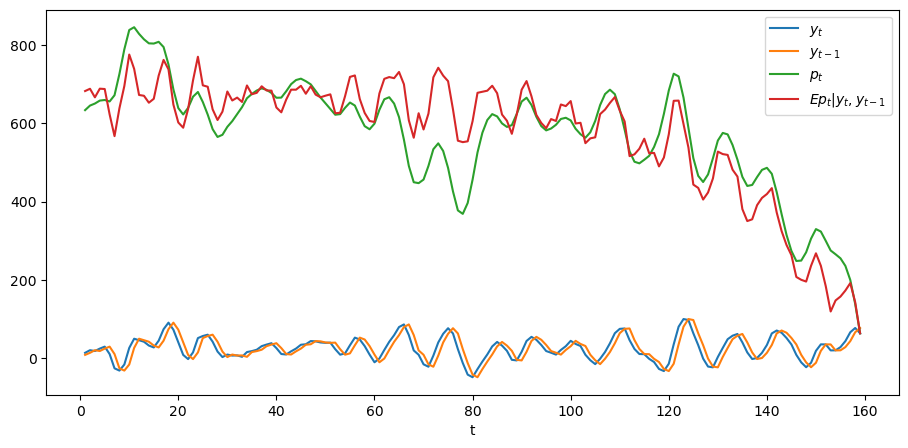

In [80]:
plt.plot(range(1, T), y[1:], label='$y_{t}$')
plt.plot(range(1, T), y[:-1], label='$y_{t-1}$')
plt.plot(range(1, T), p[1:], label='$p_{t}$')
plt.plot(range(1, T), cond_Ep, label='$Ep_{t}|y_{t}, y_{t-1}$')

plt.xlabel('t')
plt.legend(loc=1)
plt.show()

In [81]:
G = np.array([[1., 3.]])
R = np.array([[1.]])

x0_hat = np.array([0., 1.])
Œ£0 = np.array([[1., .5], [.3, 2.]])

Œº = np.hstack([x0_hat, G @ x0_hat])
Œ£ = np.block([[Œ£0, Œ£0 @ G.T], [G @ Œ£0, G @ Œ£0 @ G.T + R]])

In [82]:
# construction of the multivariate normal instance
multi_normal = MultivariateNormal(Œº, Œ£)

In [83]:
multi_normal.partition(2)

In [84]:
# the observation of y
y0 = 2.3

# conditional distribution of x0
Œº1_hat, Œ£11 = multi_normal.cond_dist(0, y0)
Œº1_hat, Œ£11

(array([-0.078125,  0.803125]),
 array([[ 0.72098214, -0.203125  ],
        [-0.403125  ,  0.228125  ]]))

In [85]:
A = np.array([[0.5, 0.2], [-0.1, 0.3]])
C = np.array([[2.], [1.]])

# conditional distribution of x1
x1_cond = A @ Œº1_hat
Œ£1_cond = C @ C.T + A @ Œ£11 @ A.T
x1_cond, Œ£1_cond

(array([0.1215625, 0.24875  ]),
 array([[4.12874554, 1.95523214],
        [1.92123214, 1.04592857]]))

In [86]:
def iterate(x0_hat, Œ£0, A, C, G, R, y_seq):

    p, n = G.shape

    T = len(y_seq)
    x_hat_seq = np.empty((T+1, n))
    Œ£_hat_seq = np.empty((T+1, n, n))

    x_hat_seq[0] = x0_hat
    Œ£_hat_seq[0] = Œ£0

    for t in range(T):
        xt_hat = x_hat_seq[t]
        Œ£t = Œ£_hat_seq[t]
        Œº = np.hstack([xt_hat, G @ xt_hat])
        Œ£ = np.block([[Œ£t, Œ£t @ G.T], [G @ Œ£t, G @ Œ£t @ G.T + R]])

        # filtering
        multi_normal = MultivariateNormal(Œº, Œ£)
        multi_normal.partition(n)
        x_tilde, Œ£_tilde = multi_normal.cond_dist(0, y_seq[t])

        # forecasting
        x_hat_seq[t+1] = A @ x_tilde
        Œ£_hat_seq[t+1] = C @ C.T + A @ Œ£_tilde @ A.T

    return x_hat_seq, Œ£_hat_seq

In [87]:
iterate(x0_hat, Œ£0, A, C, G, R, [2.3, 1.2, 3.2])

(array([[0.        , 1.        ],
        [0.1215625 , 0.24875   ],
        [0.18680212, 0.06904689],
        [0.75576875, 0.05558463]]),
 array([[[1.        , 0.5       ],
         [0.3       , 2.        ]],
 
        [[4.12874554, 1.95523214],
         [1.92123214, 1.04592857]],
 
        [[4.08198663, 1.99218488],
         [1.98640488, 1.00886423]],
 
        [[4.06457628, 2.00041999],
         [1.99943739, 1.00275526]]]))

In [88]:
N = 10
k = 2

In [89]:
Œõ = np.zeros((N, k))
Œõ[:N//2, 0] = 1
Œõ[N//2:, 1] = 1

œÉu = .5
D = np.eye(N) * œÉu ** 2

In [90]:
# compute Œ£y
Œ£y = Œõ @ Œõ.T + D

In [91]:
Œºz = np.zeros(k+N)

Œ£z = np.empty((k+N, k+N))

Œ£z[:k, :k] = np.eye(k)
Œ£z[:k, k:] = Œõ.T
Œ£z[k:, :k] = Œõ
Œ£z[k:, k:] = Œ£y

In [92]:
z = np.random.multivariate_normal(Œºz, Œ£z)

f = z[:k]
y = z[k:]

In [93]:
multi_normal_factor = MultivariateNormal(Œºz, Œ£z)
multi_normal_factor.partition(k)

In [94]:
multi_normal_factor.cond_dist(0, y)

(array([-0.62375778, -0.30432477]),
 array([[0.04761905, 0.        ],
        [0.        , 0.04761905]]))

In [95]:
B = Œõ.T @ np.linalg.inv(Œ£y)

B @ y

array([-0.62375778, -0.30432477])

In [96]:
multi_normal_factor.cond_dist(1, f)

(array([ 0.19693034,  0.19693034,  0.19693034,  0.19693034,  0.19693034,
        -0.24543556, -0.24543556, -0.24543556, -0.24543556, -0.24543556]),
 array([[0.25, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
        [0.  , 0.25, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.25, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.25, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.  , 0.25, 0.  , 0.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.  , 0.  , 0.25, 0.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.25, 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.25, 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.25, 0.  ],
        [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.25]]))

In [97]:
Œõ @ f

array([ 0.19693034,  0.19693034,  0.19693034,  0.19693034,  0.19693034,
       -0.24543556, -0.24543556, -0.24543556, -0.24543556, -0.24543556])

In [98]:
ùúÜ_tilde, P = np.linalg.eigh(Œ£y)

# arrange the eigenvectors by eigenvalues
ind = sorted(range(N), key=lambda x: ùúÜ_tilde[x], reverse=True)

P = P[:, ind]
ùúÜ_tilde = ùúÜ_tilde[ind]
Œõ_tilde = np.diag(ùúÜ_tilde)

print('ùúÜ_tilde =', ùúÜ_tilde)

ùúÜ_tilde = [5.25 5.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25]


In [99]:
# verify the orthogonality of eigenvectors
np.abs(P @ P.T - np.eye(N)).max()

4.440892098500626e-16

In [100]:
# verify the eigenvalue decomposition is correct
P @ Œõ_tilde @ P.T

array([[1.25, 1.  , 1.  , 1.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [1.  , 1.25, 1.  , 1.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [1.  , 1.  , 1.25, 1.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [1.  , 1.  , 1.  , 1.25, 1.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [1.  , 1.  , 1.  , 1.  , 1.25, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 1.25, 1.  , 1.  , 1.  , 1.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 1.25, 1.  , 1.  , 1.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 1.  , 1.25, 1.  , 1.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 1.  , 1.  , 1.25, 1.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 1.  , 1.  , 1.  , 1.25]])

In [101]:
Œµ = P.T @ y

print("Œµ = ", Œµ)

Œµ =  [-0.71451541 -1.46450304  0.54565796  1.09330071  0.19222449 -0.54512087
  0.0437469   0.74632421 -0.4369276  -0.79915891]


In [102]:
# print the values of the two factors

print('f = ', f)

f =  [ 0.19693034 -0.24543556]


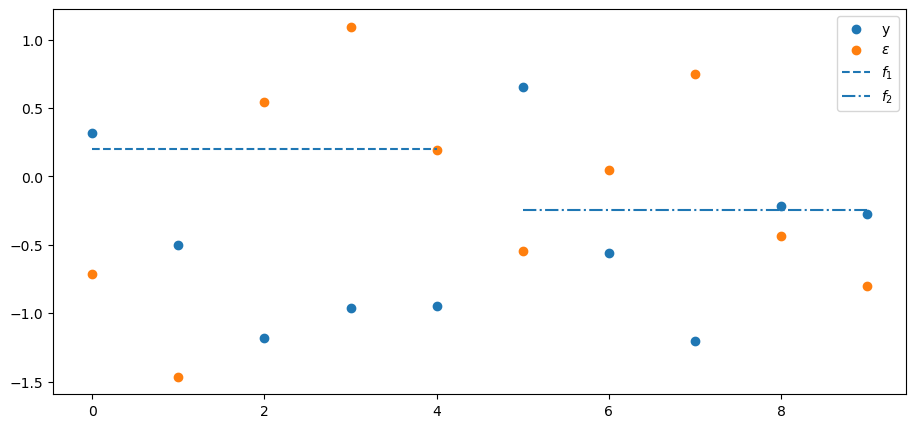

In [103]:
plt.scatter(range(N), y, label='y')
plt.scatter(range(N), Œµ, label='$\epsilon$')
plt.hlines(f[0], 0, N//2-1, ls='--', label='$f_{1}$')
plt.hlines(f[1], N//2, N-1, ls='-.', label='$f_{2}$')
plt.legend()

plt.show()

In [104]:
Œµ[:2]

array([-0.71451541, -1.46450304])

In [105]:
# compare with Ef|y
B @ y

array([-0.62375778, -0.30432477])

In [106]:
ùúÜ_tilde[:2].sum() / ùúÜ_tilde.sum()

0.8400000000000002

In [107]:
y_hat = P[:, :2] @ Œµ[:2]

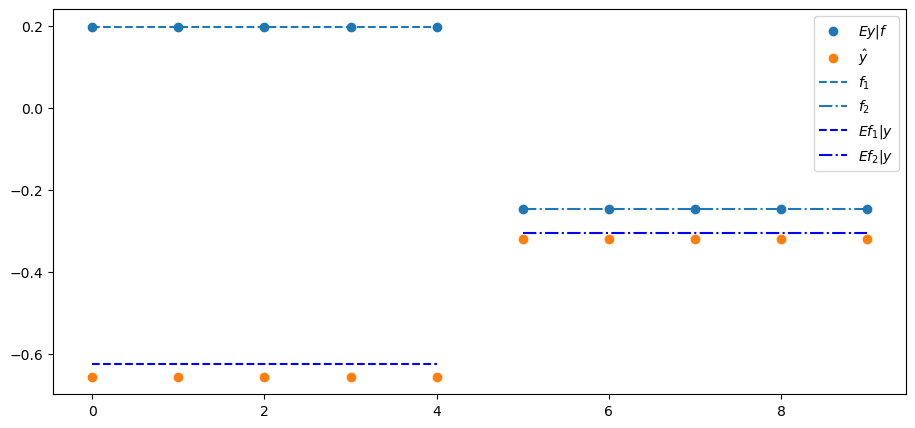

In [108]:
plt.scatter(range(N), Œõ @ f, label='$Ey|f$')
plt.scatter(range(N), y_hat, label='$\hat{y}$')
plt.hlines(f[0], 0, N//2-1, ls='--', label='$f_{1}$')
plt.hlines(f[1], N//2, N-1, ls='-.', label='$f_{2}$')

Efy = B @ y
plt.hlines(Efy[0], 0, N//2-1, ls='--', color='b', label='$Ef_{1}|y$')
plt.hlines(Efy[1], N//2, N-1, ls='-.', color='b', label='$Ef_{2}|y$')
plt.legend()

plt.show()

In [109]:
Œ£Œµjk = (P.T @ Œ£y @ P)[:2, :2]

Pjk = P[:, :2]

Œ£y_hat = Pjk @ Œ£Œµjk @ Pjk.T
print('Œ£y_hat = \n', Œ£y_hat)

Œ£y_hat = 
 [[1.05 1.05 1.05 1.05 1.05 0.   0.   0.   0.   0.  ]
 [1.05 1.05 1.05 1.05 1.05 0.   0.   0.   0.   0.  ]
 [1.05 1.05 1.05 1.05 1.05 0.   0.   0.   0.   0.  ]
 [1.05 1.05 1.05 1.05 1.05 0.   0.   0.   0.   0.  ]
 [1.05 1.05 1.05 1.05 1.05 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   1.05 1.05 1.05 1.05 1.05]
 [0.   0.   0.   0.   0.   1.05 1.05 1.05 1.05 1.05]
 [0.   0.   0.   0.   0.   1.05 1.05 1.05 1.05 1.05]
 [0.   0.   0.   0.   0.   1.05 1.05 1.05 1.05 1.05]
 [0.   0.   0.   0.   0.   1.05 1.05 1.05 1.05 1.05]]
